# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import lusee
import sys, os
from scipy.interpolate import interp1d
sys.path.append('/home/anze/work/lusee/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator

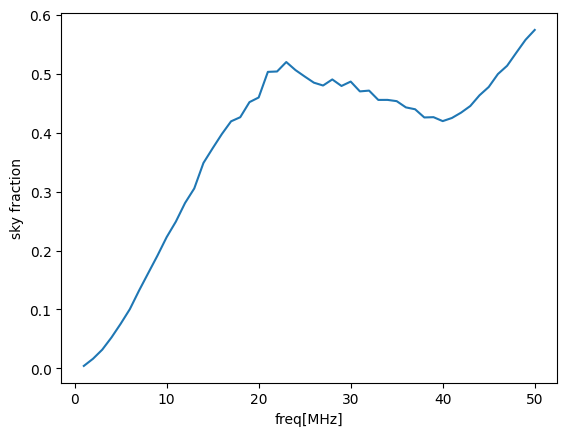

In [2]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

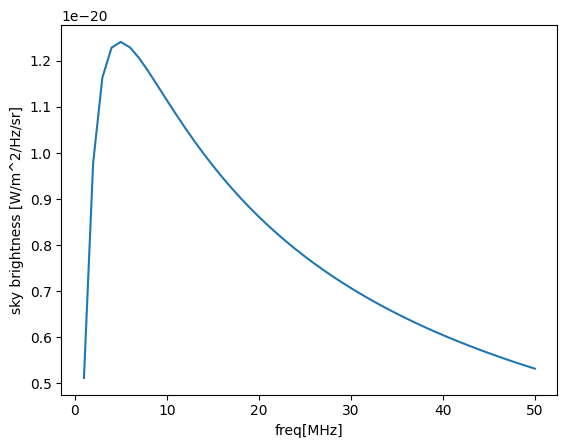

In [3]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq))
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 4.999999999999999e-19 W/m^2


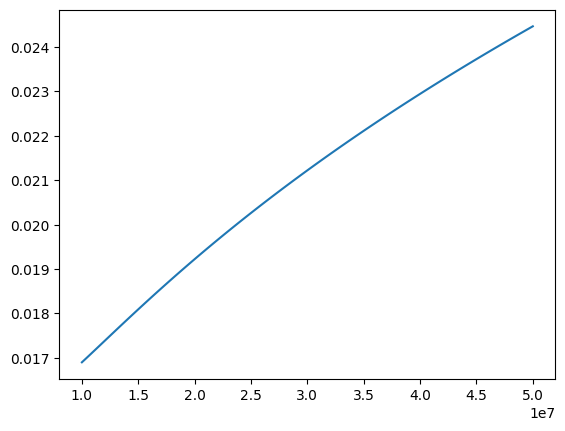

In [4]:
# define signal and sky signals
req_level = 5e-24 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

def signal_rms(freq):
    freq_MHz = freq/1e6
    sf = sky_fraction(freq_MHz)
    return np.sqrt(req_level*sf)

def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area
    return np.sqrt(sky_signal)

freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [5]:
precompensation = np.load('/home/anze/work/lusee/notebooks/calibrator/precompensation.npz')['precomp']
antenna = 1/np.copy(precompensation)
x= np.arange(512)
precompensation_fix = precompensation*(1+60*np.exp(-(x-230)**2/(2*20**2)))
precompensation_fix/=precompensation_fix.sum()


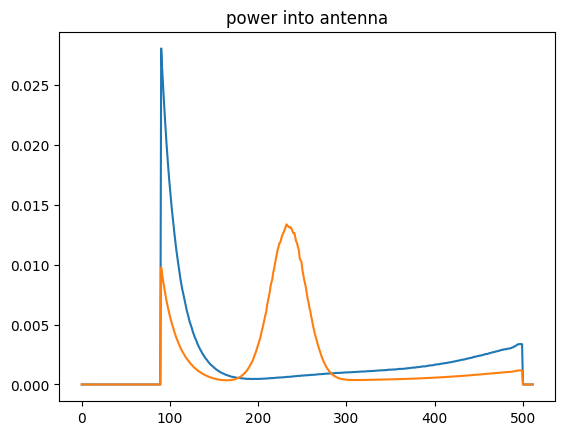

In [6]:
plt.title('power into antenna')
plt.plot(precompensation)
plt.plot(precompensation_fix)

2.3910794939627773


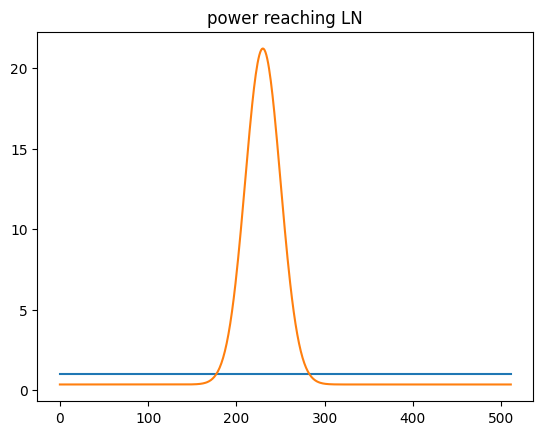

In [7]:
plt.title('power reaching LN')
plt.plot(precompensation*antenna)
plt.plot(precompensation_fix*antenna)
print ((precompensation_fix*antenna).sum()/(precompensation*antenna).sum())

In [10]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms, precompensation=precompensation_fix, antenna=antenna)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=128)
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=-0.3,tmax=3,force_detect=True)
res['detect'], res['SNRdBdet']

-9.936640091903005e-10 -0.001396371831085973 True
1.6352949947832417e-10 -0.0017006026430475111 True
-2.3147260097859266e-09 -0.0018208543390379043 True
1.1536943712303152e-09 -0.0015945752334030861 True
1.0293952834605645e-09 -0.001760659785268803 True
7.731240193209016e-10 -0.0018049202649062842 True
7.356835081810036e-10 -0.0015843243697124967 True
-1.394757827547215e-09 -0.0017093467590294997 True
5.710722000352145e-09 -0.0013865160221304962 True
-8.831253086944735e-09 -0.0014653590512998661 True
4.759390340066218e-09 -0.0016641421590688787 True
-1.493666323575568e-09 -0.0016744902214835071 True
4.063343500941758e-09 -0.0016921099679713951 True
-1.613476087177582e-09 -0.0014987894053658062 True
3.837277802311862e-10 -0.0015978340045622685 True
-5.350755184053625e-09 -0.0017134469547404412 True
6.799176660385168e-09 -0.0012207622470035704 True
-1.3012777077923306e-09 -0.001595190492190663 True
-6.265470867460309e-09 -0.0016414471740413088 True
7.128450568258443e-10 -0.00155371711884

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([5.8167573 , 5.83184153, 6.10275104, 5.87476097, 6.47157884,
        6.29053243, 5.66876922, 6.3122689 , 6.1132561 , 5.96895364,
        6.54375786, 6.12754328, 6.04961857, 6.11586261, 5.71182145,
        5.97808061, 5.49827979, 6.47660774, 5.59633958, 5.76262991,
        6.31521452, 6.79150439, 6.55313287, 6.256487  , 6.40104011,
        5.92476703, 5.66307156, 5.7878261 , 5.86205327, 5.73356158,
        5.29829745, 6.226469  , 5.82804749, 5.79326949, 6.00610023,
        5.78346478, 6.61722637]))

rms= 0.007070574572297559


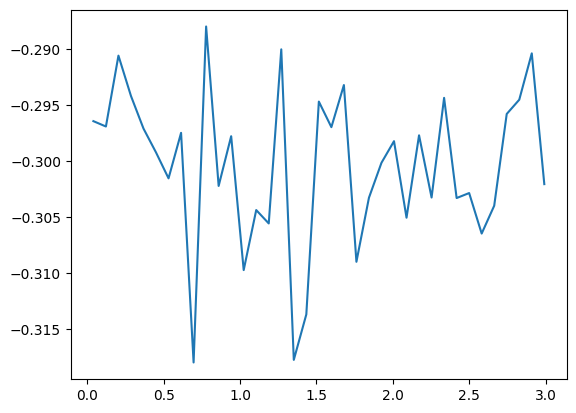

In [11]:
plt.plot(res['t'], res['alphadet'])

print('rms=',res['alphadet'].std())

In [113]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms,pilot_idx=[300],pilot_boost=15)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

pilot_boost 15
non_pilot_boost 0.6633249580710799


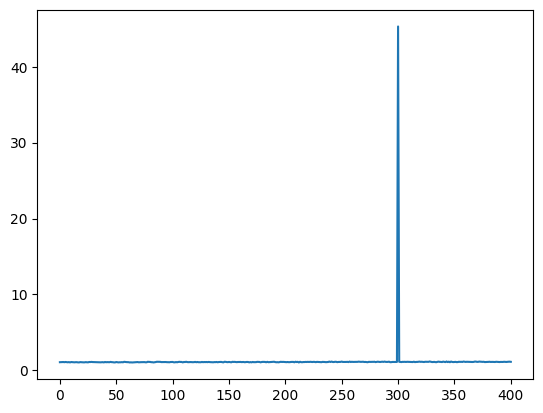

In [114]:
plt.plot(nb/wb)
